In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import scipy.optimize

import math
import matplotlib.pyplot as plt
%matplotlib inline

## Part 1

Using a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and counterparty firm values. You should simulate the values monthly, and should have LIBOR forward rates applying over one month, starting one month apart, up to maturity. You mayassume that the counterparty firm and stock values are uncorrelated with LIBOR forward rates. 

In [4]:
# Parameters initialization
T = 1       #option maturity
L = 150     #up-and-out barrier
S0 = 100    #current share price
K = 100     #strike price, at-the-money


v_0 = 200   #current counterparty firm value
debt = 175  #counterparty's debt, due in one year 
corr = 0.2  #correlation between counterparty and the stock
recovery_rate = 0.25 #recovery rate with the counterparty


corr_matrix = np.array([[1, corr], [corr, 1]])
sample_size = 1000000

sigma_const = 0.30
gamma = 0.75

In [55]:
# Initializing the given zero-coupon bond prices and maturity
    
t = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])/12

zcb_prices = np.array([99.38, 98.76, 98.15, 97.54, 96.94, 96.34, 95.74, 95.16, 94.57, 93.99, 93.42, 92.85])/100

Now, we'll create functions to calculate the simulated bond prices from the Vasicek model and define function F which is the differences between the bond prices calculated by our model and actual market zero-coupon bond prices:

In [134]:
def A(t1, t2, alpha):
    return (1-np.exp(-alpha*(t2-t1)))/alpha
def D(t1, t2, alpha, b, sigma):
    val1 = (t2-t1-A(t1,t2,alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return val1-val2

def bond_price_fun(r,t,T, alpha, b, sigma):
    return np.exp(-A(t,T,alpha)*r+D(t,T,alpha,b,sigma))


def F(x):
    alpha = x[0]
    b = x[1]
    sigma = x[2]
    r0 = x[3]
    return sum(np.abs(bond_price_fun(r0,0,t,alpha,b,sigma)-zcb_prices))

The fmin_slsqp function from scipy is will then be used to optimize model parameters and compute a minimum value of F.

In [135]:
#Optimizing the model parameters and minimizing the value of F
bnds = ((0,1),(0,0.2),(0,0.2), (0.00,0.10))
opt_val = scipy.optimize.fmin_slsqp(F, (0.3, 0.05, 0.03, 0.05), bounds=bnds)
opt_alpha = opt_val[0]
opt_b = opt_val[1]
opt_sigma = opt_val[2]
opt_r0 = opt_val[3]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0002564991015950868
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


In [136]:
#Printing out the optimized model parameters.
print("The optimized model parameters are given as: Optimal alpha: {:.3f}, Optimal b: {:.3f}, Optimal sigma {:.3f} and Optimal r0: {:.3f}".format(opt_val[0], opt_val[1], opt_val[2], opt_val[3]))

The optimized model parameters are given as: Optimal alpha: 0.273, Optimal b: 0.069, Optimal sigma 0.028 and Optimal r0: 0.075


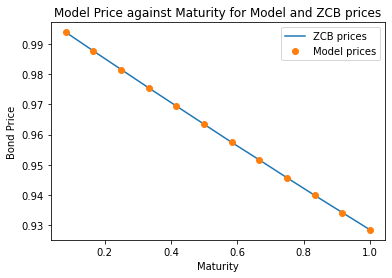

In [139]:
#Plotting Model Prices and ZCB prices for comparison
model_prices = bond_price_fun(opt_r0,0,t, opt_alpha, opt_b, opt_sigma)
model_yield = -np.log(model_prices)/t

plt.title('Model Price against Maturity for Model and ZCB prices')
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t,zcb_prices, label ="ZCB prices")
plt.plot(t, model_prices, 'o', label="Model prices")
plt.legend()
plt.show()

### Simulate LIBOR rate paths

We use paramters we obtained above to recreate the Vasicek bond prices:

In [142]:
def A(t1, t2):
    return (1-np.exp(-opt_alpha*(t2-t1)))/opt_alpha

def C(t1, t2):
    val1 = (t2-t1-A(t1,t2))*(opt_sigma**2/(2*opt_alpha**2)-opt_b)
    val2 = opt_sigma**2*A(t1,t2)**2/(4*opt_alpha)
    return val1 - val2

def bond_price(r,t,T):
    return np.exp(-A(t,T)*r+C(t,T))

vasi_bond = bond_price(opt_r0, 0, t)

Notice that the prices calculated from the Vasicek model are close to the ZCB prices given by the assignment as seen in the values printed below:

In [144]:
a = list(vasi_bond.round(4))
b = list(zcb_prices.round(4))

data = {"Vasicek prices": a, "ZCB prices": b}

In [145]:
compared_prices = pd.DataFrame(data=data)

In [146]:
compared_prices

,Vasicek prices,ZCB prices
0,0.9938,0.9938
1,0.9876,0.9876
2,0.9815,0.9815
3,0.9754,0.9754
4,0.9694,0.9694
5,0.9634,0.9634
6,0.9575,0.9574
7,0.9516,0.9516
8,0.9457,0.9457
9,0.9399,0.9399


We now initialize the matrices we will use to store the Monte Carlo simulations, for both basic Monte Carlo and Predictor-Corrector method.

In [147]:
n_simulations = sample_size
n_steps = len(t)

mc_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_capfac = np.ones([n_simulations, n_steps])
mc_capfac = np.ones([n_simulations, n_steps])

delta = np.ones([n_simulations, n_steps - 1])*(t[1:]-t[:-1])

We now run the Monte Carlo simulation for each time step:

In [148]:
for i in range(1, n_steps):
    Z = norm.rvs(size=[n_simulations,1])
    
    muhat = np.cumsum(delta[:, i:]*mc_forward[:, i:]*sigmaj**2/(1+delta[:, i:]*mc_forward[:,i:]), axis=1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]), axis=1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp), axis=1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/2+sigmaj*np.sqrt(delta[:,i:])*Z)

From our Monte Carlo simulation, we now calculate the capitalization factors and bond prices, and plot them to compare them with the Vasicek bond prices.

In [149]:
#Initialize parameter 
sigmaj = 0.2

mc_capfac[:,1:] = np.cumprod(1+mc_forward, axis=1)
predcorr_capfac[:,1:] = np.cumprod(1+predcorr_forward, axis=1)

mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

mc_final = np.mean(mc_price, axis=0)
predcorr_final = np.mean(predcorr_price, axis=0)

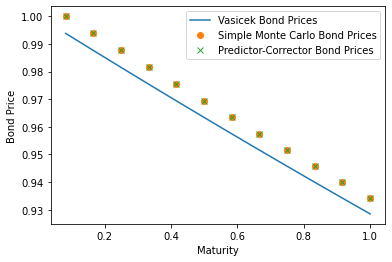

In [150]:
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(t,vasi_bond, label="Vasicek Bond Prices")

plt.plot(t, mc_final, 'o', label="Simple Monte Carlo Bond Prices")
plt.plot(t, predcorr_final, 'x', label="Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

From our simulation of forward rates (we take the Predictor-Corrector method, we use the formula  to obtain the continuous compounded interest rates:

In [151]:
r_sim = np.log(1 + predcorr_forward*(delta))/delta

We also calculate an annualized form of the interest rates:

In [152]:
r_sim_annualized = pd.DataFrame(r_sim/delta)

In [167]:
r_sim_annualized.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.075009,0.076983,0.074785,0.077681,0.077840,0.079827,0.082209,0.081586,0.082309,0.084216,0.079728
1,0.075009,0.074168,0.072387,0.075957,0.077825,0.081399,0.080611,0.085578,0.081628,0.080933,0.086858
2,0.075009,0.073470,0.077313,0.083863,0.082410,0.071902,0.071831,0.075321,0.072717,0.076838,0.077191
3,0.075009,0.072389,0.077989,0.078956,0.084110,0.082257,0.081288,0.092364,0.092043,0.099377,0.101639
4,0.075009,0.073048,0.077532,0.084396,0.084850,0.083326,0.086879,0.095179,0.098419,0.100196,0.098959


Generate stock and firm values

Similar to the first groupwork assignment, we use a Cholesky decomposition to generate the correlated price paths

In [154]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, Z, varying_vol = True):

    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)
    
    return prev_price*np.exp(np.cumsum((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z,1))

def generate_share_and_firm_price(S0, v_0, r_sim, sigma_const, gamma, corr, T, sample_size, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    
    share_price_path = pd.DataFrame(next_share_price(S0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,0,]))
    share_price_path = share_price_path.transpose()
    
    first_row = pd.DataFrame([S0]*sample_size)
    first_row = first_row.transpose()
    share_price_path = pd.concat([first_row, share_price_path])
    share_price_path = share_price_path.reset_index(drop=True)

    firm_price_path = pd.DataFrame(next_share_price(v_0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,1,]))
    firm_price_path = firm_price_path.transpose()
    
    first_row = pd.DataFrame([v_0]*sample_size)
    first_row = first_row.transpose()
    firm_price_path = pd.concat([first_row, firm_price_path])
    firm_price_path = firm_price_path.reset_index(drop=True)

    return [share_price_path,firm_price_path]  

In [155]:
share_prices, firm_prices = generate_share_and_firm_price(S0, v_0, r_sim_annualized, sigma_const, gamma, corr, T, sample_size, timesteps = 11)

We then print out the share price and firm value paths:

In [168]:
share_prices.head()

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,96.909492,100.609469,101.106167,99.201676,101.953559,94.246442,102.101305,100.952579,105.272065,97.245005,...,94.104915,100.986777,101.731986,101.485236,106.433829,100.271138,100.066769,105.208018,103.569005,97.558029
2,96.619298,104.065419,102.762040,102.406669,103.660963,96.348851,104.225491,106.758373,102.885459,99.536544,...,94.476183,106.464894,100.245046,103.570711,104.105239,107.511937,100.311748,108.325370,107.135549,100.553813
3,98.070465,100.227932,102.213906,98.728630,104.455060,97.280250,109.439765,107.408257,104.235678,107.786638,...,92.750112,109.617240,102.299972,103.491632,100.670060,106.617014,108.111342,110.366833,110.672261,96.926234
4,95.824871,101.669479,103.617296,102.877369,104.014263,99.205363,106.531582,103.001812,98.674431,105.986974,...,91.993494,108.448241,106.567124,103.835211,100.645493,106.772742,105.289709,112.653331,105.038267,99.881573


In [169]:
firm_prices.head()

,0,1,2,3,4,5,6,7,8,9,...,999990,999991,999992,999993,999994,999995,999996,999997,999998,999999
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
1,200.255378,198.663305,195.606340,208.137886,201.172101,192.418501,201.899629,203.239408,214.079319,197.488541,...,198.425726,203.789221,204.778516,203.144241,205.593473,197.758570,195.434527,200.068493,199.935846,196.642283
2,195.007082,207.225429,200.324964,215.008742,208.682251,189.579483,204.552682,206.540604,220.835859,201.985451,...,206.685680,208.395223,207.152554,207.719687,208.805105,204.300102,195.251950,197.709131,197.964586,194.749829
3,194.167985,205.388656,197.999287,209.316110,207.550002,186.119824,210.121351,210.718597,211.205080,205.898358,...,199.999421,213.523860,214.225182,207.994386,207.516834,203.793135,200.059514,206.287394,204.163266,193.492425
4,202.177537,205.233272,200.153248,211.833870,208.155001,189.284394,215.741479,214.665700,212.038245,204.572223,...,202.730686,206.183231,212.631603,208.172777,214.272844,213.512377,197.826349,201.964610,208.984277,194.382469


We also plot the first 1000 stock price and firm value paths simulated:

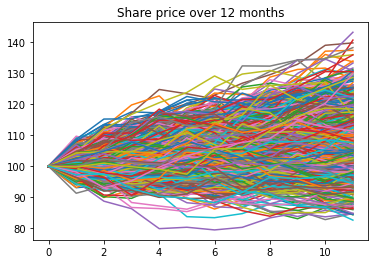

In [158]:
share_prices.iloc[:,0:1000].plot(title='Share price over 12 months', legend=False);

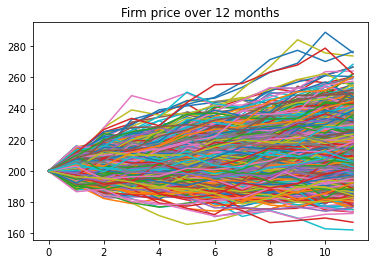

In [159]:
firm_prices.iloc[:,0:1000].plot(title='Firm price over 12 months', legend=False);

## Part 2

Calculate the one-year discount factor which applies for each simulation, and use this to find first the value of the option for the jointly simulated stock and firm paths with no default risk, and then the value of the option with counterparty default risk. (Hint: you may want to use the reshape and ravel attributes of numpy arrays to ensure your dimensions match correctly.

In [160]:
one_year_disc_fac = 1/np.cumprod(1+r_sim,1)[:,-1]
one_year_disc_fac

array([0.93012006, 0.93010646, 0.93276599, ..., 0.93278315, 0.92495773,
       0.91243027])

In [161]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

In [162]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []


payoffs = payoff(share_prices, K, L)
option_price = one_year_disc_fac*payoffs
option_estimate = option_price.mean()
option_std = option_price.std()/np.sqrt(sample_size)

In [163]:
print("Default-free option price {:.3f}".format(option_estimate))
print("Default-free option price standard deviation {:.3f}".format(option_std))

Default-free option price 8.347
Default-free option price standard deviation 0.008


In [164]:
payoffs = payoff(share_prices, K, L)
term_firm_vals = firm_prices.iloc[-1].to_numpy()
amount_lost = one_year_disc_fac*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
cva_estimate = amount_lost.mean()
cva_std = amount_lost.std()/np.sqrt(sample_size)

option_cva_price = option_price - amount_lost
option_cva_adjusted_prices = option_cva_price.mean()
option_cva_adjusted_std = option_cva_price.std()/np.sqrt(sample_size)

In [165]:
print("Credit value adjustment {:.3f}".format(cva_estimate))
print("Credit value adjustment standard deviation {:.3f}".format(cva_std))

print("CVA-adjusted option price {:.3f}".format(option_cva_adjusted_prices))
print("CVA-adjusted option price standard deviation {:.3f}".format(option_cva_adjusted_std))

Credit value adjustment 0.017
Credit value adjustment standard deviation 0.000
CVA-adjusted option price 8.330
CVA-adjusted option price standard deviation 0.008


## Part 3

If you bought the option (rather than sold it), how does your own credit risk affect the value
of the option?

## Part 4

Suppose interest rates increased 25 basis points. What is the new value of your option?